$$

    f(a) = e^{-\int_0^a{(1+\epsilon(a, s))\mu(s) ds}}\\
    \mu(s) = \mu_{ub} - (\mu_{ub} - \mu_{lb})\frac{s^{m}}{s^{m} + K^{m}}

$$

$$
\epsilon(a, s) = 
\begin{cases}
    0 & \text{if } s < a - t_e \\
    \epsilon_0 e^{-\tau|a-t_e|} e^{-\lambda(t_e-(a-s))} & \text{otherwise }
\end{cases}
$$

In [2]:
from survival_analysis import *
import pandas as pd

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


In [3]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]
sector_params_MLE = dict(zip(sector_list, parameters))

In [1]:
from one_tail_dip import *
from hill import *
import matplotlib.pyplot as plt

def onetail_dip_model(df_analysis, sector_params_MLE, sector):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess = [0.1, 0.05, 10, 5, find_dip(df_analysis, sector), 3, 1, 0.1]

    result = mlefit_hill_with_dip(ages, survivors, totals, initial_guess)
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x
    print("Fitted parameters (with dip):")
    print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}")

    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'AIC with dip = {aic_with_dip} \n AIC original = {aic_original}')
    bic_original = 2 * 4 + np.log(len(ages) * len(survivors)) * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    bic_with_dip = 2 * 8 + np.log(len(ages) * len(survivors)) * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'BIC with dip = {bic_with_dip} \n BIC original = {bic_original}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

    return (aic_with_dip, aic_original), (bic_with_dip, bic_original)

--- Sector G ---
Fitted parameters (with dip):
mu_ub: 0.12726864194112503, mu_lb: 0.03807641459678071, K: 13.71120913748422, m: 4.4862513420005845, t_e: 8.25647560175015, eps0: 7.23507011659395, tau: 1.5283646874049974, lam: 1.5283646874049974
AIC with dip = 395465.4667404475 
 AIC original = 396597.3040134779
BIC with dip = 395545.63690515305 
 BIC original = 396637.3890958306


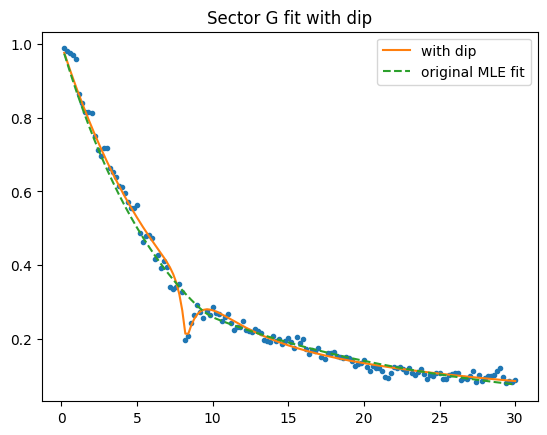

--- Sector H ---
Fitted parameters (with dip):
mu_ub: 0.08957383952818533, mu_lb: 0.001, K: 22.8314305439425, m: 22.749081288010935, t_e: 6.846661431150933, eps0: 2.3618809756875567, tau: 0.5997111550309087, lam: 1.0124037332474174e-05
AIC with dip = 83364.77346243674 
 AIC original = 85957.70099236167
BIC with dip = 83444.94362714229 
 BIC original = 85997.78607471444


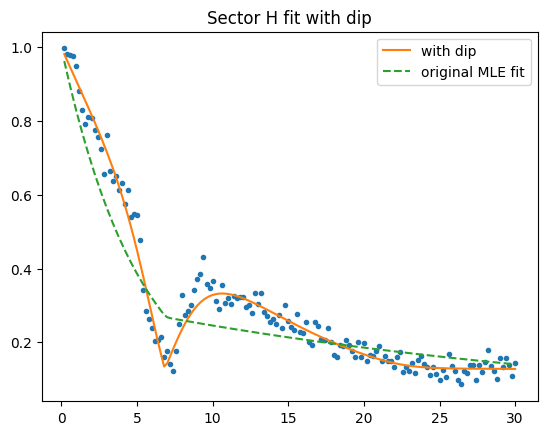

--- Sector S ---
Fitted parameters (with dip):
mu_ub: 0.13575945832518316, mu_lb: 0.00100000000004331, K: 13.471550710726323, m: 5.56094897605973, t_e: 8.27161565431276, eps0: 20.0, tau: 5.338904754844598, lam: 2.992999345020199
AIC with dip = 71390.04937605289 
 AIC original = 71512.57347341714
BIC with dip = 71470.21954075844 
 BIC original = 71552.65855576991


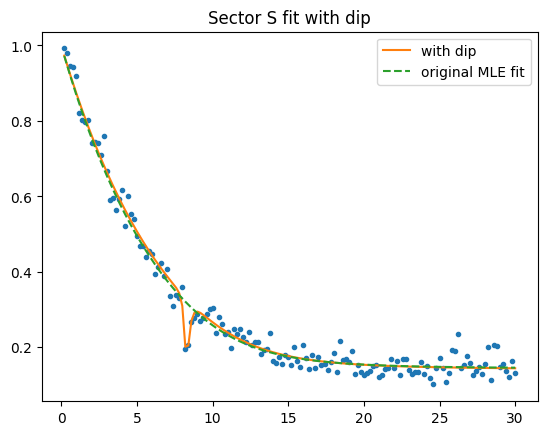

--- Sector J ---
Fitted parameters (with dip):
mu_ub: 0.12386920809591377, mu_lb: 0.05999938747915055, K: 10.708234222907398, m: 20.025989614607692, t_e: 4.539268793101835, eps0: 3.94807446311566, tau: 2.6186694273969437, lam: 1.2959522833249877
AIC with dip = 113661.75510107588 
 AIC original = 113961.26472763256
BIC with dip = 113741.92526578142 
 BIC original = 114001.34980998533


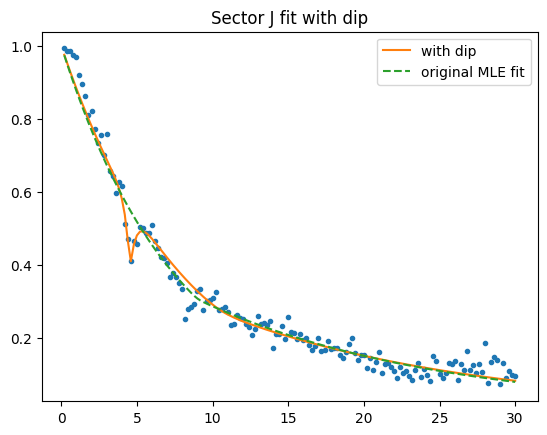

--- Sector M ---
Fitted parameters (with dip):
mu_ub: 0.08602912723274525, mu_lb: 0.001, K: 23.84464012789956, m: 18.818110188658686, t_e: 7.966494691738405, eps0: 0.9944906284146442, tau: 0.19651001121782555, lam: 0.1965100111983791
AIC with dip = 213206.91659917575 
 AIC original = 213792.9742091233
BIC with dip = 213287.0867638813 
 BIC original = 213833.05929147606


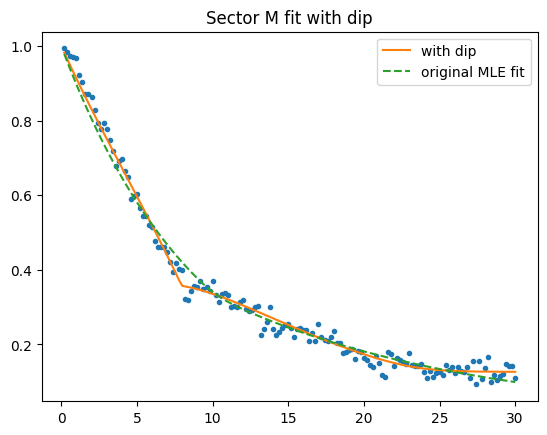

--- Sector I ---
Fitted parameters (with dip):
mu_ub: 0.124435319584067, mu_lb: 0.0010000000000000072, K: 20.894230527407018, m: 4.547079200816678, t_e: 5.199953232413778, eps0: 3.028887224422073, tau: 2.5726864703655052, lam: 2.5726864703655004
AIC with dip = 68490.03635116188 
 AIC original = 68503.12634688056
BIC with dip = 68570.20651586742 
 BIC original = 68543.21142923333


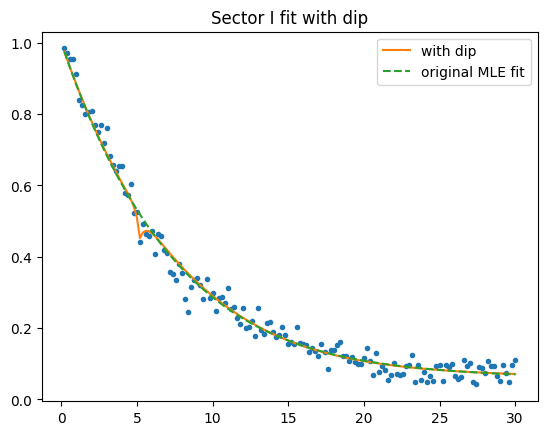

In [4]:
test_list = ['G', 'H', 'S', 'J', 'M', 'I']
aic_dip_list = []
aic_original_list = []
bic_dip_list = []
bic_original_list = []

for sector in test_list:
    print(f'--- Sector {sector} ---')
    aic, bic = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(aic[0])
    aic_original_list.append(bic[1])  
    bic_dip_list.append(bic[0])
    bic_original_list.append(bic[1])  

In [5]:
aic_series = pd.Series(dict(zip(test_list, aic_dip_list)), index=test_list)
aic_original_series = pd.Series(dict(zip(test_list, aic_original_list)), index=test_list)
# Join the two series into a DataFrame
aic_df = pd.DataFrame({'AIC with Dip': aic_series, 'AIC Original': aic_original_series})
print(aic_df)

    AIC with Dip   AIC Original
G  395465.466740  396637.389096
H   83364.773462   85997.786075
S   71390.049376   71552.658556
J  113661.755101  114001.349810
M  213206.916599  213833.059291
I   68490.036351   68543.211429


In [6]:
bic_series = pd.Series(dict(zip(test_list, bic_dip_list)), index=test_list)
bic_original_series = pd.Series(dict(zip(test_list, bic_original_list)), index=test_list)
# Join the two series into a DataFrame
bic_df = pd.DataFrame({'BIC with Dip': bic_series, 'BIC Original': bic_original_series})
print(bic_df)

    BIC with Dip   BIC Original
G  395545.636905  396637.389096
H   83444.943627   85997.786075
S   71470.219541   71552.658556
J  113741.925266  114001.349810
M  213287.086764  213833.059291
I   68570.206516   68543.211429


--- Sector F ---
Fitted parameters (with dip):
mu_ub: 0.07758775241525354, mu_lb: 0.07758775142046728, K: 12.962010102564422, m: 2.4169909726840273, t_e: 5.379966009625431, eps0: 1.4757633354459083, tau: 1.1468262539878342, lam: 0.8757146546779027
AIC with dip = 95554.70272850509 
 AIC original = 95571.32745895388
BIC with dip = 95634.87289321063 
 BIC original = 95611.41254130665


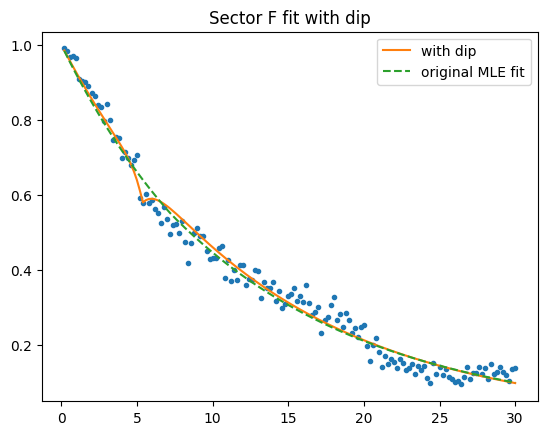

--- Sector P ---


c:\Users\chong\OneDrive\Documents\GitHub\a-star\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.0887121228462275, mu_lb: 0.08871211584505052, K: 12.969166788178102, m: 0.5, t_e: 8.239774810848505, eps0: 0.9638251753537213, tau: 0.13557699225545305, lam: 0.13557699246658733
AIC with dip = 50220.202895297596 
 AIC original = 50319.80915009245
BIC with dip = 50300.373060003134 
 BIC original = 50359.89423244522


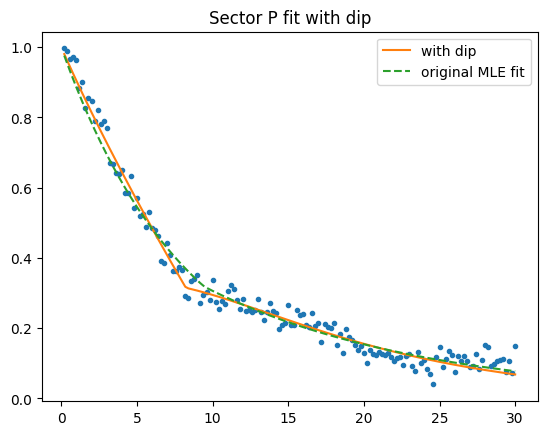

--- Sector K ---


c:\Users\chong\OneDrive\Documents\GitHub\a-star\one_tail_dip.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.06633747495923505, mu_lb: 0.0010000000736666676, K: 20.09139759342859, m: 12.865350460735424, t_e: 7.677663296749926, eps0: 0.6964784050896804, tau: 0.37091607798312526, lam: 0.3709160989053461
AIC with dip = 112363.6502826821 
 AIC original = 112433.7547534963
BIC with dip = 112443.82044738764 
 BIC original = 112473.83983584907


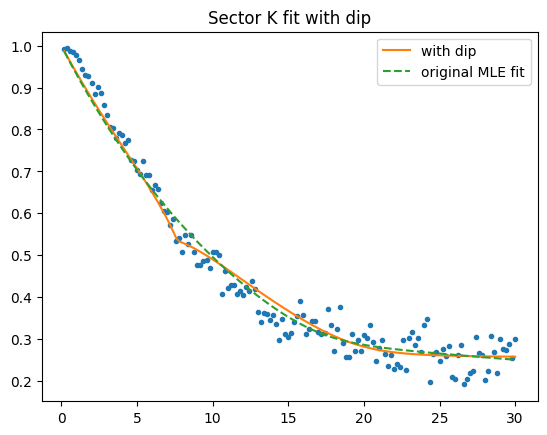

In [7]:
test_list = ['F', 'P', 'K']
aic_dip_list = []
aic_original_list = []
bic_dip_list = []
bic_original_list = []

for sector in test_list:
    print(f'--- Sector {sector} ---')
    aic, bic = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(aic[0])
    aic_original_list.append(bic[1])
    bic_dip_list.append(bic[0])
    bic_original_list.append(bic[1])

In [8]:
aic_series = pd.Series(dict(zip(test_list, aic_dip_list)), index=test_list)
aic_original_series = pd.Series(dict(zip(test_list, aic_original_list)), index=test_list)
# Join the two series into a DataFrame
aic_df = pd.DataFrame({'AIC with Dip': aic_series, 'AIC Original': aic_original_series})
print(aic_df)

bic_series = pd.Series(dict(zip(test_list, bic_dip_list)), index=test_list)
bic_original_series = pd.Series(dict(zip(test_list, bic_original_list)), index=test_list)
# Join the two series into a DataFrame
bic_df = pd.DataFrame({'BIC with Dip': bic_series, 'BIC Original': bic_original_series})
print(bic_df)

    AIC with Dip   AIC Original
F   95554.702729   95611.412541
P   50220.202895   50359.894232
K  112363.650283  112473.839836
    BIC with Dip   BIC Original
F   95634.872893   95611.412541
P   50300.373060   50359.894232
K  112443.820447  112473.839836
